# Vorhersage Industrieller Daten

## 1. Einleitung

### Problemstellung
In vielen technischen und industriellen Anwendungen ist es notwendig, zeitabhängige Kennzahlen zuverlässig vorherzusagen. Typische Beispiele sind:
- **Energieverbrauch** von Maschinen oder Gebäuden  
- **Durchsatz** in Produktionsanlagen  
- **Ausfallraten** oder Wartungsbedarfe von Systemen  

Diese Größen liegen meist als **Zeitreihen** vor und unterliegen Trends, saisonalen Effekten sowie zufälligen Schwankungen.

### Was ist Forecasting?
Forecasting (Zeitreihenprognose) bezeichnet die Vorhersage zukünftiger Werte auf Basis historischer Daten. Dabei werden statistische oder maschinelle Lernverfahren eingesetzt, um Muster in der Vergangenheit zu erkennen und in die Zukunft fortzuschreiben.

### Motivation
Kurz- bis mittelfristige Vorhersagen sind besonders wichtig, um:
- Ressourcen effizient zu planen (z. B. Energie, Personal),
- Ausfälle frühzeitig zu erkennen,
- Kosten zu reduzieren und
- fundierte Entscheidungen auf Basis von Daten zu treffen.

### Ziel des Notebooks
Ziel dieses Jupyter Notebooks ist es, **klassische Zeitreihenmodelle** mit **modernen Ansätzen** zu vergleichen:
- Klassisch: **ARIMA**
- Modern: **Prophet** und ein einfaches **LSTM-Netzwerk**

Die Modelle werden hinsichtlich Prognosequalität, Interpretierbarkeit und Implementierungsaufwand gegenübergestellt.


## 2. Datenbeschreibung

### Herkunft des Datensatzes
Der verwendete Datensatz stammt von kaggle.com und ist ein öffentlich verfügbarer Beispieldatensatz. Er beschreibt den elektrischen Energieverbrauch einer Stahlfabrik und wird häufig für Analysen im Bereich industrieller Zeitreihen und Energieprognosen eingesetzt.

### Enthaltene Variablen
Der Datensatz liegt im **CSV-Format** vor und enthält folgende Variablen: (siehe auch Später df.info() ausgabe)

- **date**: Zeitstempel der Messung  
- **Usage_kWh**: Elektrischer Energieverbrauch in Kilowattstunden (Zielgröße)  
- **Lagging_Current_Reactive.Power_kVarh**: Nachlaufende Blindleistung  
- **Leading_Current_Reactive_Power_kVarh**: Vorlaufende Blindleistung  
- **CO2(tCO2)**: Geschätzte CO₂-Emissionen  
- **Lagging_Current_Power_Factor**: Leistungsfaktor (nachlaufend)  
- **Leading_Current_Power_Factor**: Leistungsfaktor (vorlaufend)  
- **NSM**: Number of Seconds from Midnight (Sekunden seit Mitternacht)  
- **WeekStatus**: Kennzeichnung von Wochentag oder Wochenende  
- **Day_of_week**: Name des Wochentages  
- **Load_Type**: Art der elektrischen Last (z. B. *Light Load*)

### Beispielhafte Ansicht des Datensatzes
Ein Auszug aus den ersten Zeilen des Datensatzes ist unten dargestellt:

In [13]:
import pandas as pd

df = pd.read_csv("../data/steel_industry_data.csv")

df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [14]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

### Zeitraum und zeitliche Auflösung
Die Daten beginnen am **01.01.2018** und liegen in einer **viertelstündlichen Auflösung (15 Minuten)** vor. Damit eignen sie sich sowohl für kurz- als auch mittelfristige Prognosen des Energieverbrauchs.

bei 35040 Datensatzeinträgen ergibt das ein Zeitraum von 365 Tagen.

In [15]:
SETS_PER_HOUR = 4
HOURS_PER_DAY = 24

print("Im Datensatz enthaltene Tage: " + str(int(len(df)/(SETS_PER_HOUR * HOURS_PER_DAY))))

Im Datensatz enthaltene Tage: 365


## 3. Explorative Datenanalyse (EDA)

### 3.1 Vorbereitung der Zeitachse
Zunächst wird die date-Spalte in ein Datetime-Format umgewandelt und als Index gesetzt. Dies ist notwendig für Zeitreihenanalysen und Visualisierungen.
hierbei muss der dayfirst parameter der Pandas function to_datetime auf True gesetzt werden, da das Datum (wie oben zu sehen) so formatiert ist.

In [16]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

## 3.2 Zeitverlauf des Energieverbrauchs
Der zeitliche Verlauf des Energieverbrauchs (Usage_kWh) gibt einen ersten Überblick über Trends, saisonale Muster und mögliche Ausreißer.


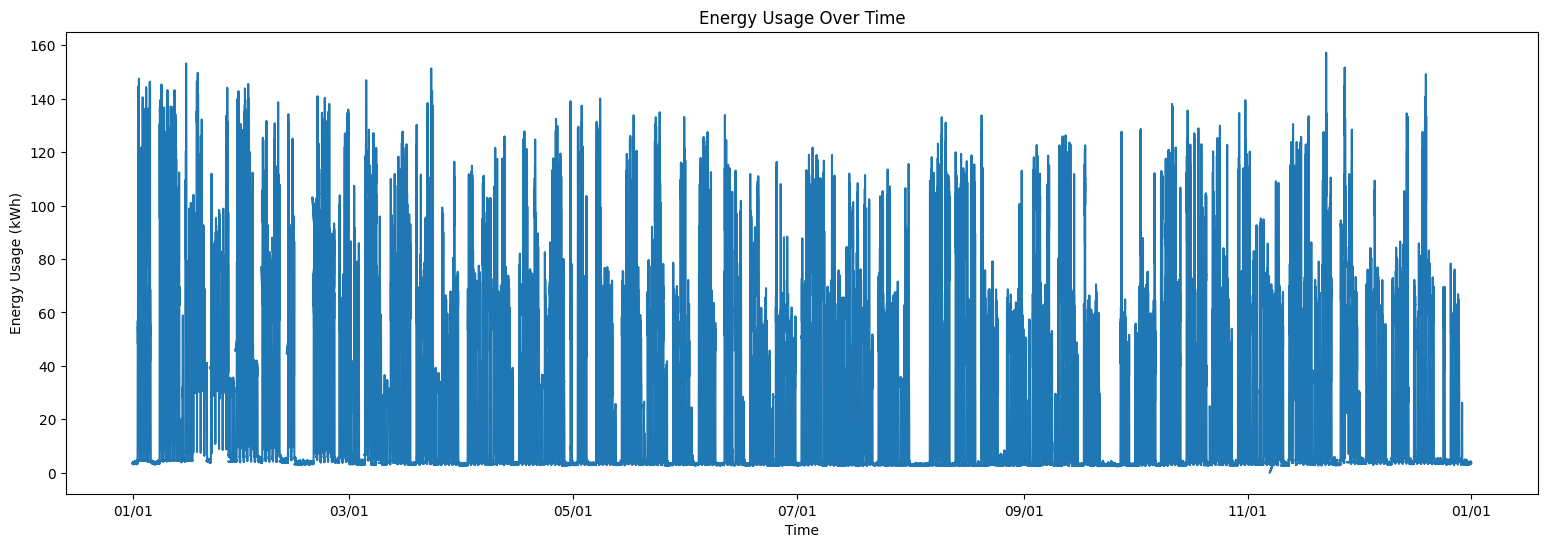

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(19,6))
plt.plot(df['date'], df['Usage_kWh'])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

plt.xlabel('Time')
plt.ylabel('Energy Usage (kWh)')
plt.title('Energy Usage Over Time')
plt.show()

Hierbei kann man schon vereinzelte saisonale Effekte beobachten, wie ca. mitte Februar, anfang August oder ende September

Um wöchtentlich oder Tägliche Muster noch besser zu erkennen kann man ein Graph mit einer Woche oder einem Tag erstellen.
Für die Woche wurde im Folgenden die Zweite kalenderwoche genutzt um mögliche Urlaube etc. auszulassen.
Für einen tag wurde der Montag gewählt, da dies einer der Klassischen Arbeitstage ist.

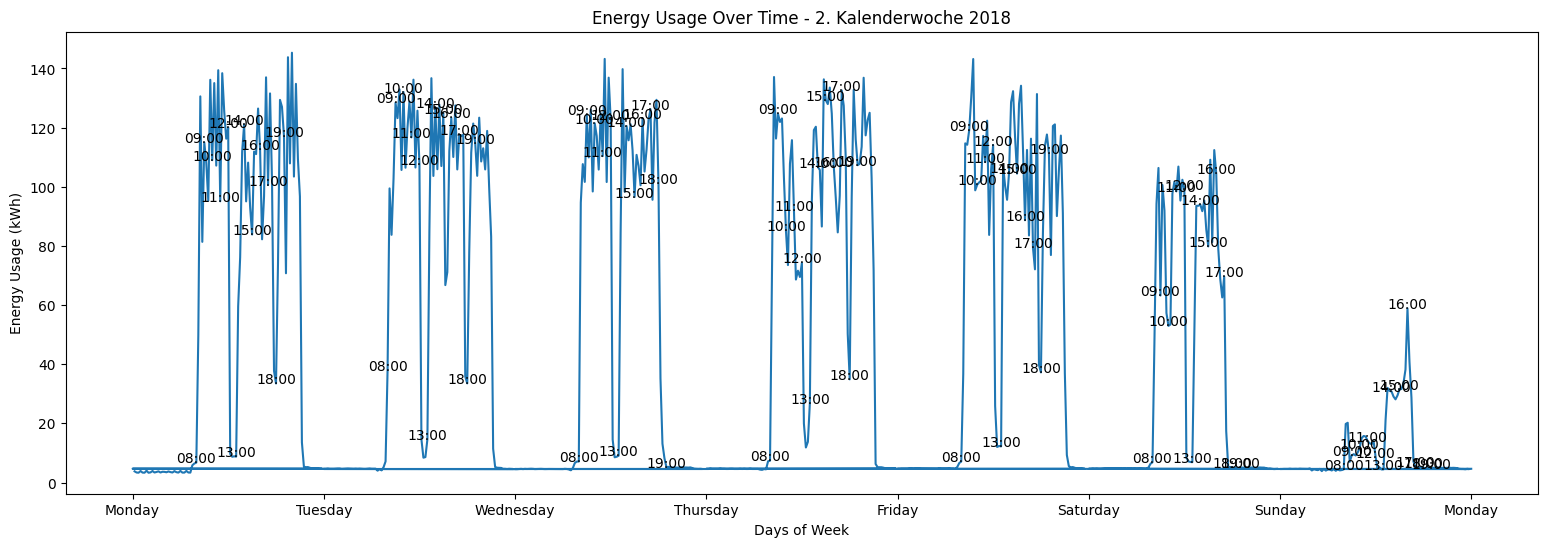

In [18]:
start_date = pd.to_datetime('2018-01-08')
end_date = pd.to_datetime('2018-01-15')

df_filtered = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

plt.figure(figsize=(19,6))
plt.plot(df_filtered['date'], df_filtered['Usage_kWh'])

for i in range(len(df_filtered)):
    if i % 4 == 3: # alle 2 Stunden ein Eintrag
        x = df_filtered['date'].iloc[i]
        if 8 <= x.hour <= 19:
            plt.text(x, df_filtered['Usage_kWh'].iloc[i], x.strftime('%H:%M'), ha='center')

plt.gca().xaxis.set_major_formatter(
    plt.matplotlib.dates.DateFormatter('%A')
)

plt.xlabel('Days of Week')
plt.ylabel('Energy Usage (kWh)')
plt.title('Energy Usage Over Time - 2. Kalenderwoche 2018')
plt.show()

#### 3.2.1 Kein langfristiger Trend innerhalb der Woche
Über die Woche hinweg ist kein klarer steigender oder fallender Gesamttrend im Sinne einer Drift nach oben/unten zu erkennen.

#### 3.2.2 Wochenstrucktur
Es gibt eine wöchentliche Saisonalität:

Montag–Freitag
- hohe, relativ stabile Tagespeaks
- ähnliche Maximalwerte

Samstag
- kürzere Aktivphase
- etwas geringere Spitzen

Sonntag
- deutlich geringerer Verbrauch
- teilweise nur kurze Aktivität oder fast Grundlast


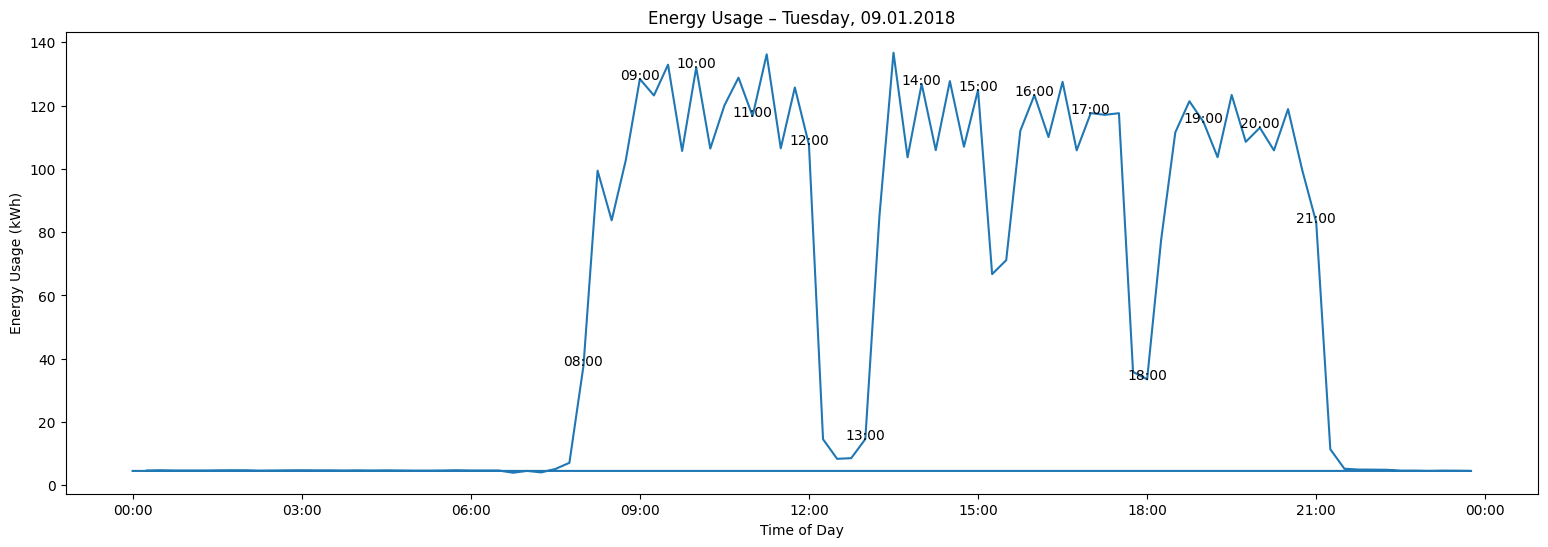

In [19]:
day = pd.to_datetime('2018-01-09')  

df_day = df[
    (df['date'].dt.date == day.date())
]

plt.figure(figsize=(19,6))
plt.plot(df_day['date'], df_day['Usage_kWh'])

for i in range(len(df_day)):
    if i % 4 == 3:
        x = df_day['date'].iloc[i]
        if 8 <= x.hour <= 21:
            plt.text(x, df_day['Usage_kWh'].iloc[i], x.strftime('%H:%M'), ha='center')

plt.gca().xaxis.set_major_formatter(
    plt.matplotlib.dates.DateFormatter('%H:%M')
)

plt.xlabel('Time of Day')
plt.ylabel('Energy Usage (kWh)')
plt.title('Energy Usage – Tuesday, 09.01.2018')
plt.show()


#### 3.2.3 Tages-Saisonalität
Der Plot wird klar dominiert von einem wiederkehrenden Tageszyklus:
- Niedriger Grundverbrauch nachts (~5 kWh)
- Abrupter Anstieg morgens (ca. 08:00)
- Kurzfristiger Abfall  (ca. 13 Uhr)
- Hohes Plateau tagsüber (ca. 90–140 kWh)
- Abfall abends (ca. 18:00–19:00)

-> Das ist typisch für Arbeitszeiten in der Industrie

#### 3.2.4 Variabilität innerhalb der Tage
Die Peak-Höhen variieren leicht (ca. 100–145 kWh)

Ein paar weitere Einbrüche während des Tages
→ mögliche Pausen, Schichtwechsel oder Maschinenabschaltungen

#### 3.2.5 Zusammenfassung
Der betrachtete Wochenausschnitt zeigt keinen ausgeprägten langfristigen Trend, sondern wird von einer starken täglichen Saisonalität sowie einer klaren Wochenstruktur (Werktage vs. Wochenende) dominiert. Der Verbrauch folgt stabilen Betriebszeiten mit hoher Reproduzierbarkeit.

### 3.3 ACF- und PACF-Analyse

Die explorative Analyse des Zeitverlaufs zeigt keine ausgeprägte langfristige Trendkomponente, jedoch eine sehr starke tägliche sowie eine wöchentliche Saisonalität.  
Insbesondere die regelmäßig wiederkehrenden Verbrauchsspitzen während der Betriebszeiten deuten auf zeitliche Abhängigkeiten zwischen aufeinanderfolgenden Beobachtungen hin.

Um diese zeitlichen Abhängigkeiten quantitativ zu untersuchen und relevante Verzögerungen (Lags) zu identifizieren, werden im nächsten Schritt die Autokorrelationsfunktion (ACF) sowie die partielle Autokorrelationsfunktion (PACF) analysiert.
Diese liefern wichtige Hinweise für die Wahl geeigneter Zeitreihenmodelle (z. B. ARIMA).


<Figure size 1400x400 with 0 Axes>

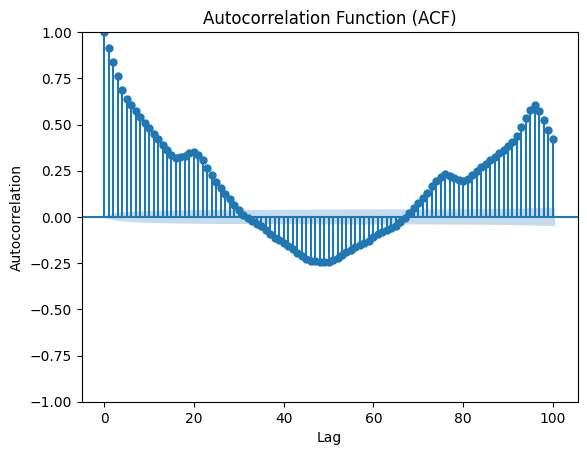

<Figure size 1400x400 with 0 Axes>

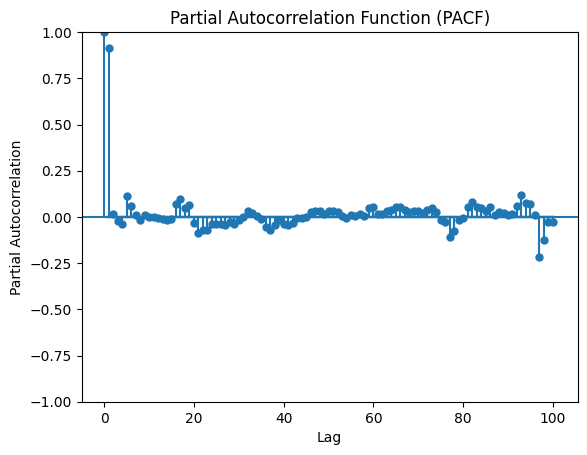

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

y = df['Usage_kWh']
y = y.dropna()

lags = 100

# ACF
plt.figure(figsize=(14,4))
plot_acf(y, lags=lags)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# PACF
plt.figure(figsize=(14,4))
plot_pacf(y, lags=lags, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


#### 3.3.1 Autokorrelationsfunktion (ACF)

Die Autokorrelationsfunktion (ACF) misst die lineare Abhängigkeit einer Zeitreihe
von ihren eigenen vergangenen Werten in Abhängigkeit vom Zeitversatz (Lag).

Die ACF zeigt für kleine Lags eine sehr hohe Autokorrelation nahe 1, die zunächst bis etwa Lag 50 kontinuierlich abnimmt. Dieses Verhalten weist auf eine starke kurzfristige zeitliche Abhängigkeit hin.

Im weiteren Verlauf steigt die Autokorrelation erneut an, bevor sie ab etwa Lag 90 wieder deutlich abfällt. Dieses periodische Muster deutet auf eine ausgeprägte intraday- und tägliche Saisonalität hin, die durch die viertelstündliche Auflösung der Daten erklärbar ist.

Insgesamt weist die langsam abklingende Autokorrelation in Kombination mit wiederkehrenden Peaks bei höheren Lags auf eine nicht-stationäre Zeitreihe mit ausgeprägten saisonalen Komponenten hin, insbesondere auf ein tägliches Verbrauchsmuster.


#### 3.3.2 Partielle Autokorrelationsfunktion (PACF)

Die partielle Autokorrelationsfunktion (PACF) misst den direkten Einfluss
eines vergangenen Wertes auf den aktuellen Wert, wobei der Einfluss
aller dazwischenliegenden Zeitpunkte herausgerechnet wird.

Im Gegensatz zur ACF zeigt die PACF somit, welche Verzögerungen einen
eigenständigen, direkten Beitrag zur Erklärung der Zeitreihe leisten.

Die signifikante Ausschläge in der PACF deuten auf autoregressive Strukturen hin
und liefern Hinweise auf die Anzahl relevanter AR-Terme (p) in einem
ARIMA-Modell.


### 3.4 Statistische Kennzahlen
Zur quantitativen Beschreibung der Verteilung des Energieverbrauchs werden zentrale statistische Kennzahlen betrachtet. Diese liefern einen kompakten Überblick über Lage, Streuung und Extremwerte der Zeitreihe.

In [21]:
mean_usage = df['Usage_kWh'].mean()
var_usage  = df['Usage_kWh'].var()
min_usage  = df['Usage_kWh'].min()
max_usage  = df['Usage_kWh'].max()

print(f"Mean Usage: {mean_usage:.2f} kWh")
print(f"Variance of Usage: {var_usage:.2f} kWh^2")
print(f"Min Usage: {min_usage:.2f} kWh")
print(f"Max Usage: {max_usage:.2f} kWh")


Mean Usage: 27.39 kWh
Variance of Usage: 1118.53 kWh^2
Min Usage: 0.00 kWh
Max Usage: 157.18 kWh


Der mittlere Energieverbrauch beträgt 27.39 kWh, was den durchschnittlichen Lastbedarf über den betrachteten Zeitraum beschreibt.

Die Varianz von 1118.53 kWh^2 verdeutlicht eine deutliche Streuung der Werte um den Mittelwert und weist auf schwankende Verbrauchsmuster im Tages- und Wochenverlauf hin.

Der minimale Verbrauch liegt bei 0.00 kWh und tritt typischerweise in Zeiten geringer Aktivität auf, während der maximale Verbrauch von 157.18 kWh auf Lastspitzen hinweist, die beispielsweise während Produktions- oder Spitzenzeiten auftreten können.

## 4 Datenvorbereitung
### 4.1 Umgang mit fehlenden Werten
Im vorliegenden Datensatz liegen keine fehlenden Werte vor, sodass keine direkte Behandlung erforderlich ist.
Nichtsdestotrotz ist der Umgang mit fehlenden Werten ein wichtiger Bestandteil der Zeitreihenvorverarbeitung und wird im Folgenden kurz erläutert.

> In Zeitreihendaten können fehlende Werte beispielsweise durch Sensorausfälle, Kommunikationsprobleme oder Wartungsintervalle entstehen. Übliche Strategien zum Umgang mit fehlenden Werten sind:
> - Vorwärts- oder Rückwärtsauffüllen (Forward/Backward Fill), sofern sich der Verbrauch nur langsam ändert
> - Interpolation (linear oder zeitbasiert), insbesondere bei kurzen Ausfällen
> - Entfernung betroffener Zeitabschnitte, falls nur wenige, isolierte Werte fehlen
> - Die Wahl der Methode hängt von Dauer, Häufigkeit und zeitlicher Struktur der fehlenden Daten ab. Bei hochfrequenten Energiedaten ist eine zeitbasierte Interpolation häufig geeignet.

Beispielcode für interpolation: 
```py
df['Usage_kWh'] = df['Usage_kWh'].interpolate(method='time')
```

### 4.2 Glättung und Resampling
Glättung bezeichnet Verfahren, mit denen kurzfristige Schwankungen (Rauschen) in einer Zeitreihe reduziert werden, um langfristige Trends oder saisonale Muster besser sichtbar zu machen.
Typische Glättungsverfahren sind:
- Gleitender Mittelwert
- Exponentielle Glättung
- Aggregiertes Resampling (z. B. von 15 Minuten auf Stunden oder Tage)

Der betrachtete Datensatz weist eine viertelstündliche Auflösung auf und zeigt ausgeprägte tägliche und wöchentliche Verbrauchsmuster, die bereits in der EDA deutlich wurden.
> Eine starke Glättung würde zwar das Rauschen reduzieren, jedoch gleichzeitig relevante kurzfristige Dynamiken und Lastspitzen entfernen, die insbesondere für die Modellierung des Energieverbrauchs von Bedeutung sind.

### 4.3 Train-Test-Split
Für Zeitreihen ist ein chronologischer Split erforderlich, um Informationsleckage zu vermeiden.

Train- und Testdaten werden getrennt, um realistisch zu prüfen, wie gut ein Modell auf unbekannte, zukünftige Daten vorhersagen kann.
- Trainingsdaten: Modell lernt Muster und Zusammenhänge
- Testdaten: Modell wird auf späteren Zeitpunkten bewertet
- Warum wichtig: Verhindert Selbsttäuschung durch Überanpassung (Overfitting)

In [22]:
train_size = int(len(df) * 0.8)

train = df.iloc[:train_size]
test  = df.iloc[train_size:]


### 4.4 Normalisierung für LSTM
Für neuronale Netze, insbesondere LSTM-Modelle, ist eine Skalierung der Daten notwendig, um eine stabile und effiziente Optimierung zu gewährleisten.
Dabei werden die originalwerte linear umgerechnet. Dadurch werden kleine Zahlen angehoben und Große Zahlen verkleinert. Das führt bei LSTM Modellen zu einem besseren lern Effekt


In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Usage_kWh']])
test_scaled  = scaler.transform(test[['Usage_kWh']])


## 5 Klassisches Modell: ARIMA

### 5.1 Theoretische Kurzbeschreibung

Das ARIMA-Modell (AutoRegressive Integrated Moving Average) ist ein klassisches statistisches Verfahren zur Modellierung und Prognose von Zeitreihen. Es basiert auf der Annahme, dass zukünftige Werte als lineare Funktion vergangener Beobachtungen und Fehlerterme beschrieben werden können.


#### 5.1.1 Stationarität

Eine zentrale Voraussetzung für die Anwendung eines ARIMA-Modells ist die **Stationarität** der Zeitreihe.  
Eine Zeitreihe gilt als stationär, wenn ihre statistischen Eigenschaften – insbesondere Mittelwert und Varianz – über die Zeit konstant bleiben.

Da reale Zeitreihen, wie der vorliegende Energieverbrauch, häufig Trends und saisonale Muster aufweisen, wird die Stationarität in der Praxis meist durch **Differenzierung** hergestellt. Dieser Prozess entfernt langfristige Trends und stabilisiert den Mittelwert der Zeitreihe.


#### 5.1.2 Bedeutung der Parameter p, d und q

Ein ARIMA-Modell wird durch drei Parameter beschrieben:

- **p (AutoRegressive Ordnung)**  
  Anzahl der vergangenen Beobachtungen, die zur Vorhersage des aktuellen Wertes herangezogen werden.

- **d (Integrationsgrad)**  
  Anzahl der Differenzierungen, die notwendig sind, um Stationarität zu erreichen.

- **q (Moving Average Ordnung)**  
  Anzahl der vergangenen Fehlerterme, die in das Modell einfließen.

Die allgemeine Notation lautet **ARIMA(p, d, q)**.


#### 5.1.3 Stärken und Schwächen des ARIMA-Modells

**Stärken:**
- Gut interpretierbar und mathematisch fundiert
- Besonders geeignet für univariate Zeitreihen
- Effektiv bei kurzfristigen Prognosen
- Geringe Modellkomplexität im Vergleich zu neuronalen Netzen

**Schwächen:**
- Erfordert stationäre Zeitreihen
- Begrenzte Fähigkeit zur Modellierung nichtlinearer Zusammenhänge
- Saisonale Effekte müssen explizit modelliert werden (z. B. SARIMA)
- Weniger geeignet für sehr komplexe oder hochdimensionale Daten


Zusammenfassend eignet sich das ARIMA-Modell gut als Baseline-Modell zur Prognose des Energieverbrauchs und ermöglicht eine transparente Bewertung der zeitlichen Abhängigkeiten in der Zeitreihe.


### 5.2 Implementierung und Parameterwahl

Die Auswahl geeigneter ARIMA-Parameter kann entweder manuell anhand von ACF- und PACF-Diagrammen oder automatisiert erfolgen.  
Im Rahmen dieser Arbeit wird die automatische Parameterwahl mit auto_arima verwendet, da sie eine systematische und reproduzierbare Bestimmung der Modellordnung ermöglicht.

---

#### 5.2.1 Automatische Parameterwahl mit auto_arima

Die Funktion auto_arima durchsucht verschiedene Kombinationen der Parameter *(p, d, q)* und wählt das Modell mit der besten Güte anhand eines Informationskriteriums (standardmäßig AIC) aus.  
Dabei werden sowohl die notwendige Differenzierung zur Herstellung der Stationarität als auch autoregressive und gleitende Anteile berücksichtigt.

In [24]:
from pmdarima import auto_arima

arima_model = auto_arima(
    train['Usage_kWh'],
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)


arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=63.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=228786.434, Time=1.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=228649.962, Time=1.66 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=228642.276, Time=3.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=228784.436, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=37.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=228616.814, Time=8.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=80.01 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=228594.932, Time=11.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=60.11 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=227720.295, Time=13.91 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=227514.812, Time=20.68 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=227502.834, Time=32.96 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=38.37 sec
 ARIMA(3,1,4)(0,0,0)[0] interce

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                28032
Model:               SARIMAX(2, 1, 5)   Log Likelihood             -113688.667
Date:                Sun, 21 Dec 2025   AIC                         227395.335
Time:                        14:25:12   BIC                         227469.504
Sample:                             0   HQIC                        227419.210
                              - 28032                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.004      0.213      0.831      -0.008       0.010
ar.L1          0.9101      0.041     21.988      0.000       0.829       0.991
ar.L2         -0.0104      0.033     -0.320      0.749      -0.074       0.053
ma.L1         -0.9927      0.042    -23.874      0.000      -1.074      -0.911
ma.L2          0.0625      0.036      1.743      0.081      -0.008       0.133
ma.L3          0.0140      0.005      2.621      0.009       0.004       0.024
ma.L4         -0.1680      0.005    -34.815      0.000      -0.177      -0.159
ma.L5          0.1147      0.006     18.321      0.000       0.102       0.127
sigma2       203.3589      0.928    219.153      0.000     201.540     205.178
===================================================================================
Ljung-Box (L1) (Q):                  10.13   Jarque-Bera (JB):            112550.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

exog_cols = [
    'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh',
    'CO2(tCO2)',
    'Lagging_Current_Power_Factor',
    'Leading_Current_Power_Factor',
    'NSM'
]

sarima_model = SARIMAX(train['Usage_kWh'], exog = train[exog_cols], order=arima_model.order)

sarima_model_fit = sarima_model.fit()
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Usage_kWh   No. Observations:                28032
Model:               SARIMAX(2, 1, 5)   Log Likelihood              -78341.484
Date:                Sun, 21 Dec 2025   AIC                         156710.967
Time:                        14:25:53   BIC                         156826.342
Sample:                             0   HQIC                        156748.107
                              - 28032                                         
Covariance Type:                  opg                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Lagging_Current_Reactive.Power_kVarh     0.6534      0.003    254.250      0.000       0.648       0.658
Leading_Current_Reactive_Power_kVarh    -0.0448      0.011     -4.061      0.000      -0.066      -0.023
CO2(tCO2)                             1166.6712      3.466    336.651      0.000    1159.879    1173.463
Lagging_Current_Power_Factor             0.3736      0.003    112.392      0.000       0.367       0.380
Leading_Current_Power_Factor             0.0985      0.003     29.561      0.000       0.092       0.105
NSM                                   -5.86e-06   4.32e-06     -1.358      0.175   -1.43e-05     2.6e-06
ar.L1                                   -0.1157      0.092     -1.252      0.211      -0.297       0.065
ar.L2                                    0.4276      0.044      9.807      0.000       0.342       0.513
ma.L1                                   -0.3339      0.092     -3.611      0.000      -0.515      -0.153
ma.L2                                   -0.5426      0.081     -6.680      0.000      -0.702      -0.383
ma.L3                                    0.1167      0.016      7.319      0.000       0.085       0.148
ma.L4                                   -0.0588      0.006    -10.398      0.000      -0.070      -0.048
ma.L5                                    0.0062      0.008      0.768      0.443      -0.010       0.022
sigma2                                  15.7302      0.071    221.875      0.000      15.591      15.869
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):             54690.03
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


### 5.2.2 Erläuterung der gefundenen Parameter
Das automatisch bestimmte Modell hat die Form:
> ARIMA(p, d, q)
> - p (autoregressiver Term):
> Gibt an, wie viele vergangene Beobachtungen zur Vorhersage herangezogen werden.
> - d (Differenzierungsgrad):
> Anzahl der Differenzierungen, die notwendig waren, um die Zeitreihe stationär zu machen.
> Ein Wert von d > 0 bestätigt die zuvor in der EDA identifizierte Nicht-Stationarität.
> - q (Moving-Average-Term):
> Beschreibt den Einfluss vergangener Fehlerterme auf den aktuellen Wert.

Die Wahl dieser Parameter reflektiert die in der ACF- und PACF-Analyse beobachteten zeitlichen Abhängigkeiten und stellt einen geeigneten Kompromiss zwischen Modellkomplexität und Prognosegüte dar.

#### 5.2.3 Interpretation der auto_arima-Ergebnisse

Das automatisch gefundene Modell lautet ARIMA(2,1,5).  

- **ar.L1 / ar.L2**: Die ersten beiden autoregressiven Terme deuten auf eine starke Abhängigkeit von den letzten zwei Zeitpunkten hin.  
- **ma.L1–ma.L5**: Die fünf gleitenden Mittelwerte zeigen, dass vergangene Fehlerterme ebenfalls signifikant zur Vorhersage beitragen.  
- **d=1**: Die Differenzierung bestätigt die zuvor identifizierte Nicht-Stationarität der Zeitreihe.

Die statistischen Kennzahlen (AIC, BIC, HQIC) und Signifikanztests der Koeffizienten zeigen, dass das Modell die zeitliche Dynamik der Energieverbrauchsdaten gut erfasst.  
Die relativ niedrige Ljung-Box-Statistik der Residuen deutet darauf hin, dass die verbleibenden Residuen kaum autokorreliert sind, was die Modellannahmen weitgehend bestätigt.  


### 5.3 Training und Evaluation
Nach der automatischen Bestimmung der Modellparameter wird das ARIMA-Modell auf den Trainingsdaten trainiert und anschließend auf den Testdaten evaluiert. Ziel ist es, die Prognosegüte auf bislang unbekannten, zukünftigen Daten zu bewerten.


#### 5.3.1 Training und Vorhersage
Das trainierte ARIMA-Modell wird verwendet, um Vorhersagen für den gesamten Testzeitraum zu erzeugen.


In [26]:
n_periods = len(test)

forecast_arima = sarima_model_fit.predict(start=len(train), end=len(train)+n_periods-1, exog=test[exog_cols])
forecast_arima = pd.Series(forecast_arima, index=test.index)

#### 5.3.2 Evaluationsmetriken
Zur Bewertung der Prognosequalität werden folgende Fehlermaße verwendet:

- **RMSE (Root Mean Squared Error):**
Bestraft größere Fehler stärker und ist sensitiv gegenüber Ausreißern

- **MAE (Mean Absolute Error):**
Durchschnittlicher absoluter Vorhersagefehler

- **MAPE (Mean Absolute Percentage Error):**
Relativer Fehler in Prozent. Berechnet als:
$$\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100\%$$

> **Hinweis zur MAPE:** Die MAPE ist anfällig für Division durch Null. Wenn tatsächliche Werte (z. B. nachts oder am Wochenende) gleich Null sind, wird MAPE undefiniert (∞). Dies tritt im vorliegenden Datensatz auf, weshalb wir primär RMSE und MAE verwenden.

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test['Usage_kWh'], forecast_arima))
mae  = mean_absolute_error(test['Usage_kWh'], forecast_arima)
mape = np.mean(np.abs((test['Usage_kWh'] - forecast_arima) / test['Usage_kWh'])) * 100

print(f"RMSE: {rmse:.8f} kWh")
print(f"MAE: {mae:.8f} kWh")
print(f"MAPE: {mape:.8f} %")

RMSE: 5.63157483 kWh
MAE: 4.27787290 kWh
MAPE: inf %


#### 5.3.3 Visualisierung Real vs. ARIMA


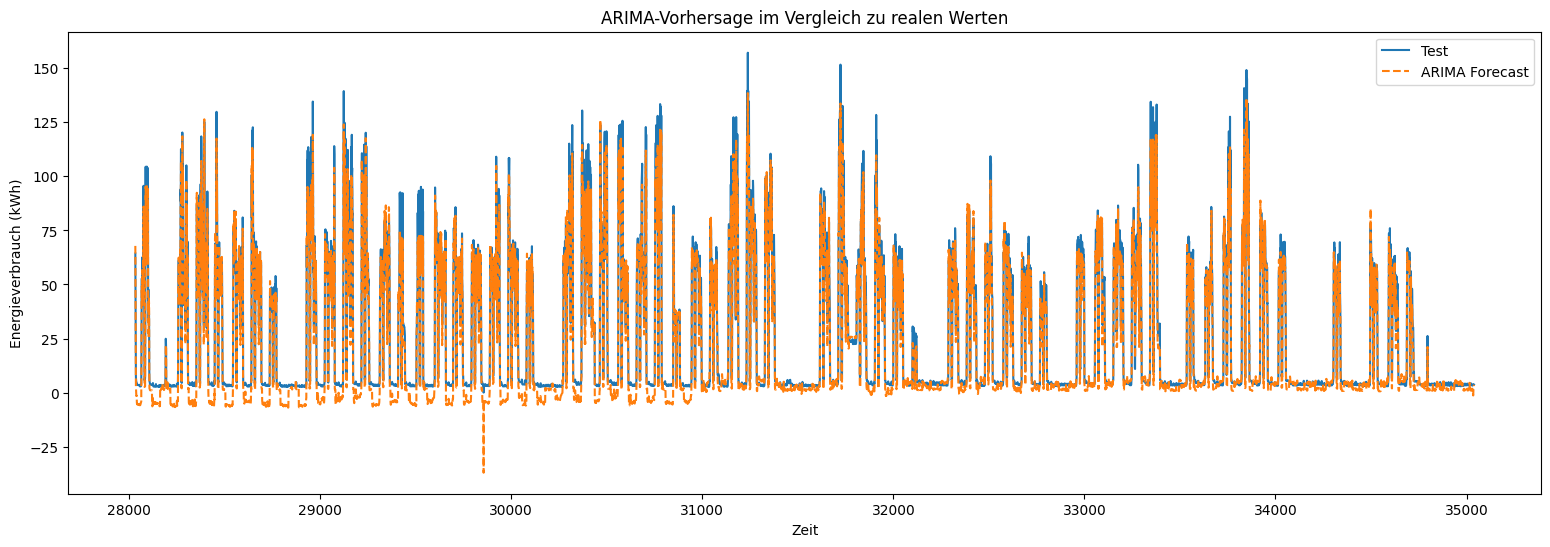

In [28]:
plt.figure(figsize=(19,6))
#plt.plot(train.index, train['Usage_kWh'], label='Training')
plt.plot(test.index, test['Usage_kWh'], label='Test')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', linestyle='--')

plt.xlabel('Zeit')
plt.ylabel('Energieverbrauch (kWh)')
plt.title('ARIMA-Vorhersage im Vergleich zu realen Werten')
plt.legend()
plt.show()


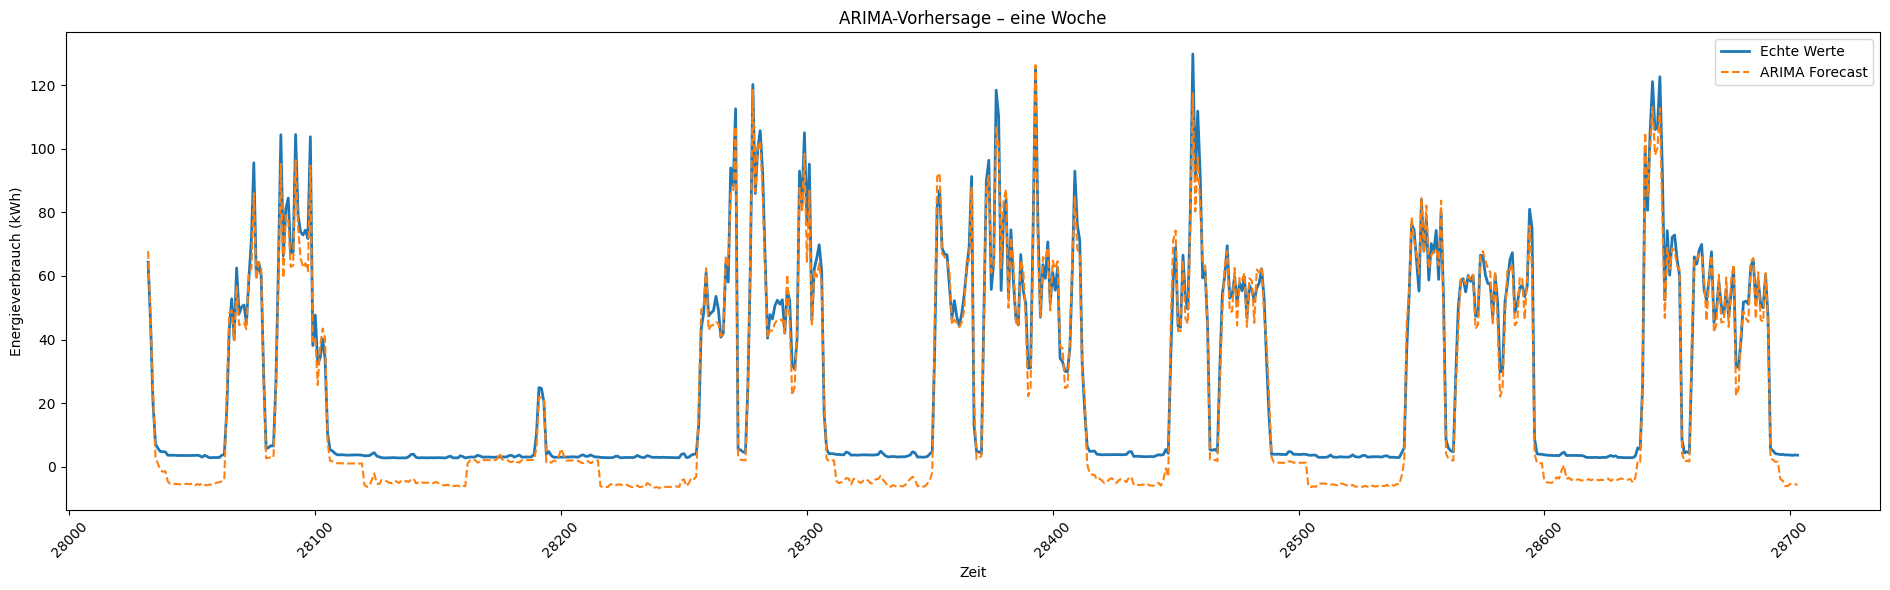

In [29]:
WEEK_STEPS = 7 * 24 * 4 

test_week = test.iloc[:WEEK_STEPS]
forecast_arima_week = forecast_arima.iloc[:WEEK_STEPS]
plt.figure(figsize=(19,6))

plt.plot(
    test_week.index,
    test_week['Usage_kWh'],
    label='Echte Werte',
    linewidth=2
)

plt.plot(
    forecast_arima_week.index,
    forecast_arima_week,
    label='ARIMA Forecast',
    linestyle='--'
)

plt.xlabel('Zeit')
plt.ylabel('Energieverbrauch (kWh)')
plt.title('ARIMA-Vorhersage – eine Woche')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 5.3.4 Residuenanalyse
Ein gut angepasstes ARIMA-Modell weist Residuen auf, die näherungsweise mittelwertfrei, homoskedastisch und unkorreliert sind.


In [30]:
residuals = test['Usage_kWh'] - forecast_arima


Zeitlicher Verlauf der Residuen:

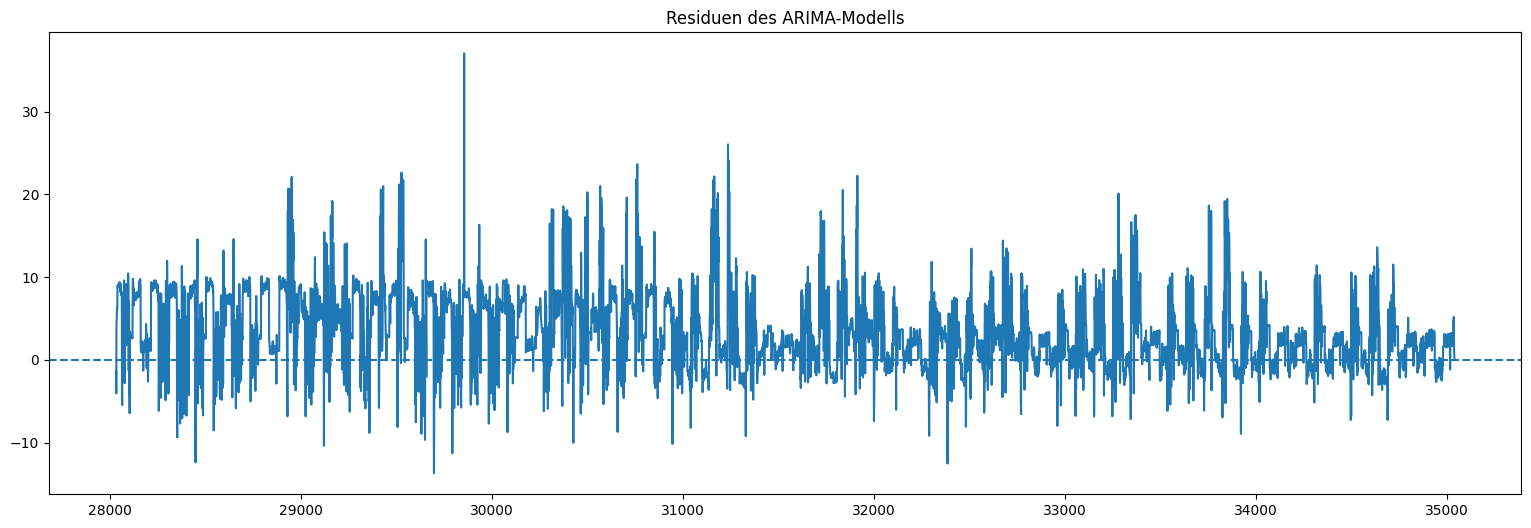

In [31]:
plt.figure(figsize=(19, 6))
plt.plot(residuals)
plt.axhline(0, linestyle='--')
plt.title('Residuen des ARIMA-Modells')
plt.show()


Autokorrelation der Residuen:

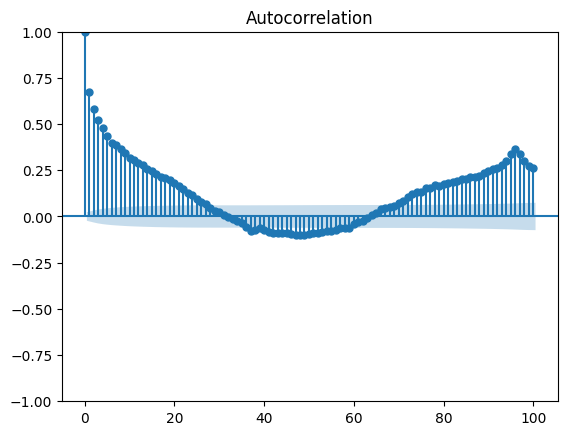

In [32]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals.dropna(), lags=100)
plt.show()


## 6 Modernes Modell: Prophet
### 6.1 Kurzbeschreibung
Prophet ist ein von Facebook entwickeltes Modell für Zeitreihenprognosen, das sich insbesondere für **stark saisonale Daten** eignet.  

- **Automatische Trend- und Saisonalitätserkennung**: Prophet trennt die Zeitreihe in **Trend-, saisonale- und Feiertagskomponenten**.  
- **Additive Komponenten**: Das Modell kombiniert Trend, Saisonalität und eventuelle Feiertagseffekte additiv.  
- **Robust gegenüber Ausreißern**: Prophet kann plötzliche Spitzen besser handhaben als klassische lineare Modelle.

> Vorteil: Keine manuelle Parameterwahl wie bei ARIMA nötig, Modell lernt selbst die wichtigste Struktur in der Zeitreihe.  
> Nachteil: Weniger interpretierbar als ARIMA bei reinen Koeffizientenanalysen.

---

### 6.2 Implementierung

Zunächst müssen die Daten in das von Prophet erwartete Format gebracht werden:

In [33]:
from prophet import Prophet
import pandas as pd

prophet_df = df[['date', 'Usage_kWh']].rename(columns={'date':'ds', 'Usage_kWh':'y'})
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

train_prophet = prophet_df.iloc[:train_size]
test_prophet  = prophet_df.iloc[train_size:]

/home/yb/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Prophet-Modell fitten

In [34]:
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive'
)

model.add_seasonality(
    name='daily',
    period=1,
    fourier_order=20 
)

model.add_seasonality(
    name='weekly',
    period=7,
    fourier_order=15
)

model.fit(train_prophet)

14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1] done processing


Optional kann man die automatisch erkannten Parameter prüfen:

In [35]:
model.params

OrderedDict([('lp__', array([[41870.028]])),
             ('k', array([[2.2735878]])),
             ('m', array([[0.17843177]])),
             ('delta',
              array([[-1.6668126e-01, -3.0120566e+00, -5.7128397e-01,  2.1474261e-08,
                       1.4749066e+00, -1.1358046e-01, -2.3633535e-07, -5.0728405e-07,
                       1.4754960e-02,  4.0915456e-06,  5.2017053e-08,  7.6531493e-07,
                       6.1208892e-07, -1.0233621e-06, -1.7153662e-03,  3.5027922e-07,
                       1.0580476e-06,  4.2464438e-01,  4.3978236e-03, -3.1943752e-01,
                      -4.3919249e-01, -2.1521949e-07,  5.1117506e-01, -5.3943700e-02,
                       1.7547283e-03]])),
             ('sigma_obs', array([[0.13550317]])),
             ('beta',
              array([[-0.04851857, -0.06837087, -0.0106159 ,  0.00174901,  0.05392578,
                       0.01586738, -0.02837801, -0.05005789,  0.03365611,  0.04413062,
                      -0.00121927,  0.0002

### 6.3 Evaluation
Vorhersage erzeugen

In [36]:
future = model.make_future_dataframe(periods=len(test_prophet), freq='15min')
forecast_prophet = model.predict(future)

start_date = test_prophet['ds'].min()
end_date = test_prophet['ds'].max()

forecast_test = forecast_prophet[(forecast_prophet['ds'] >= start_date) & (forecast_prophet['ds'] <= end_date)]


Visualisierung der Vorhersage

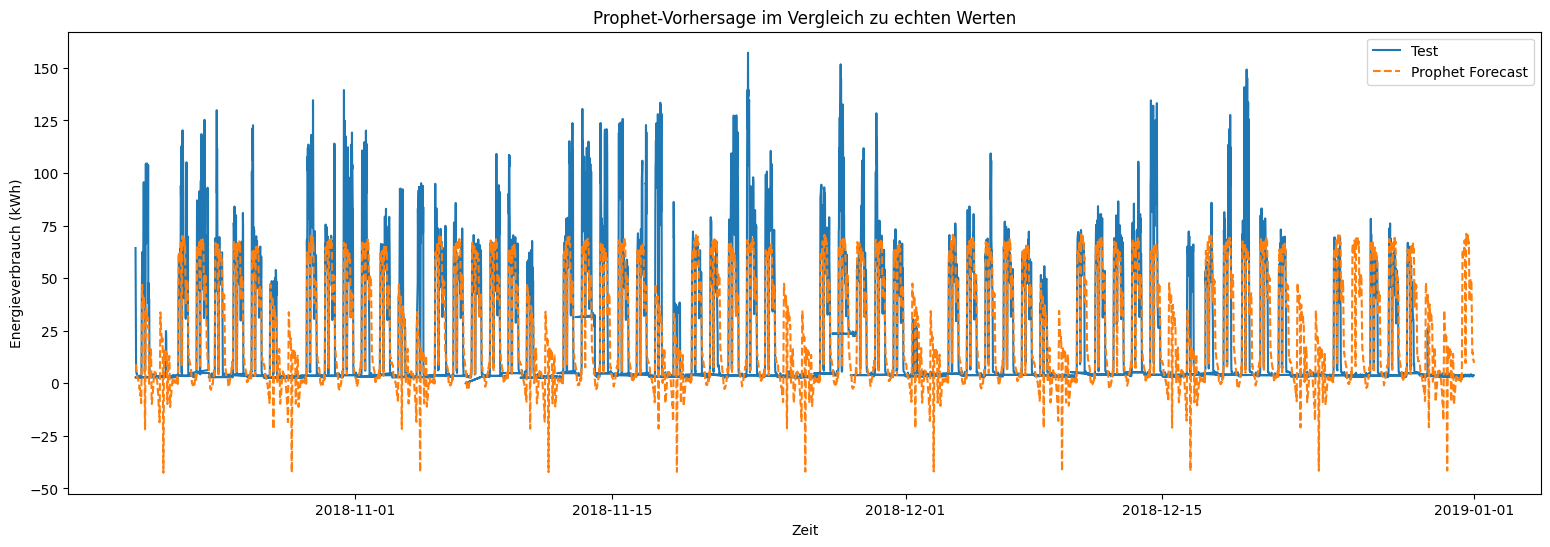

In [37]:
plt.figure(figsize=(19,6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Test')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Prophet Forecast', linestyle='--')
plt.xlabel('Zeit')
plt.ylabel('Energieverbrauch (kWh)')
plt.title('Prophet-Vorhersage im Vergleich zu echten Werten')
plt.legend()
plt.show()


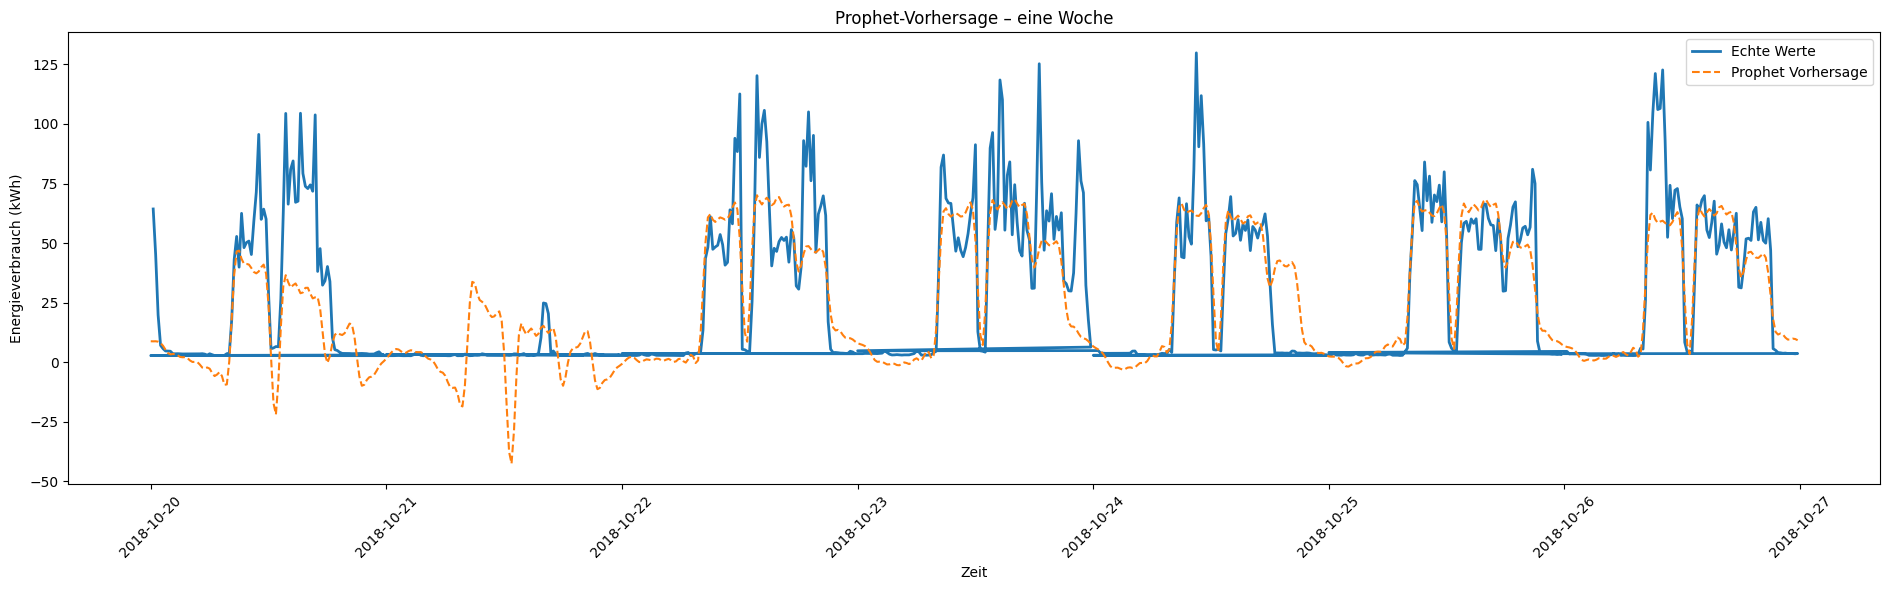

In [38]:
WEEK_STEPS = 7 * 24 * 4

forecast_test = forecast_prophet.iloc[-len(test_prophet):].copy()

forecast_prophet_week = forecast_test.iloc[:WEEK_STEPS]
test_week = test_prophet.iloc[:WEEK_STEPS]


plt.figure(figsize=(19,6))
plt.plot(test_week['ds'], test_week['y'], label='Echte Werte', linewidth=2)
plt.plot(forecast_prophet_week['ds'], forecast_prophet_week['yhat'], label='Prophet Vorhersage', linestyle='--')

plt.xlabel('Zeit')
plt.ylabel('Energieverbrauch (kWh)')
plt.title('Prophet-Vorhersage – eine Woche')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Berechnung der Evaluationsmetriken

In [39]:
y_true = test_prophet['y'].values
y_pred = forecast_prophet['yhat'].iloc[-len(test_prophet):].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"RMSE: {rmse:.4f} kWh")
print(f"MAE: {mae:.4f} kWh")
print(f"MAPE: {mape:.2f} %")


RMSE: 20.0306 kWh
MAE: 12.8682 kWh
MAPE: inf %


/tmp/ipykernel_41420/3638188498.py:6: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Komponentenvisualisierung

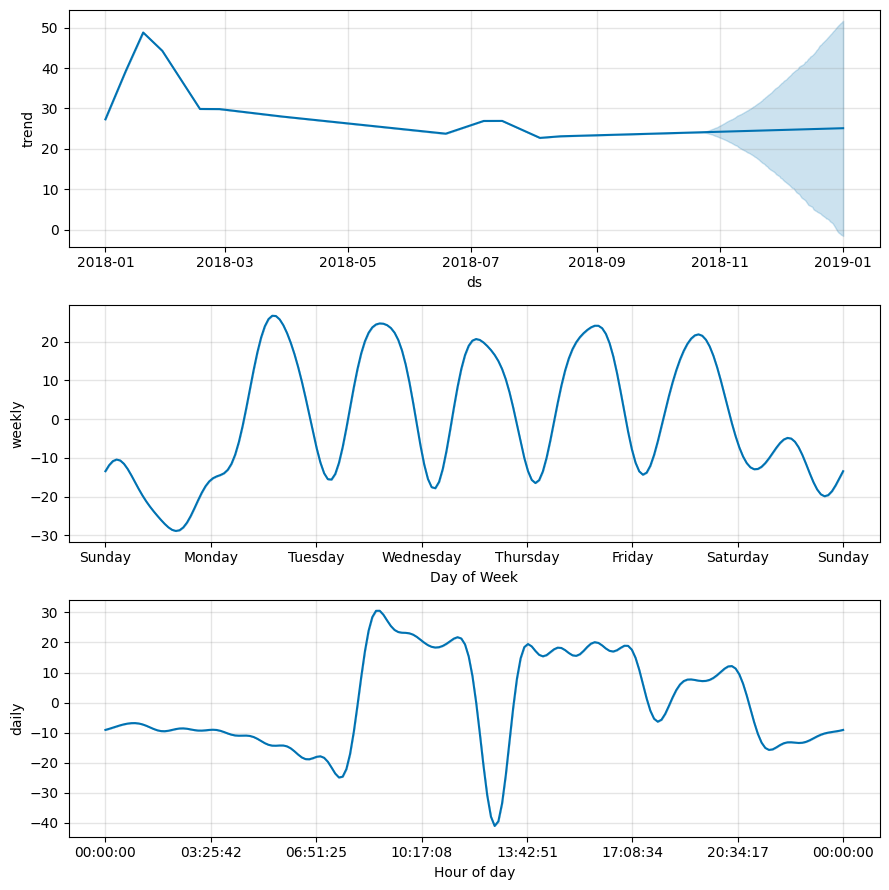

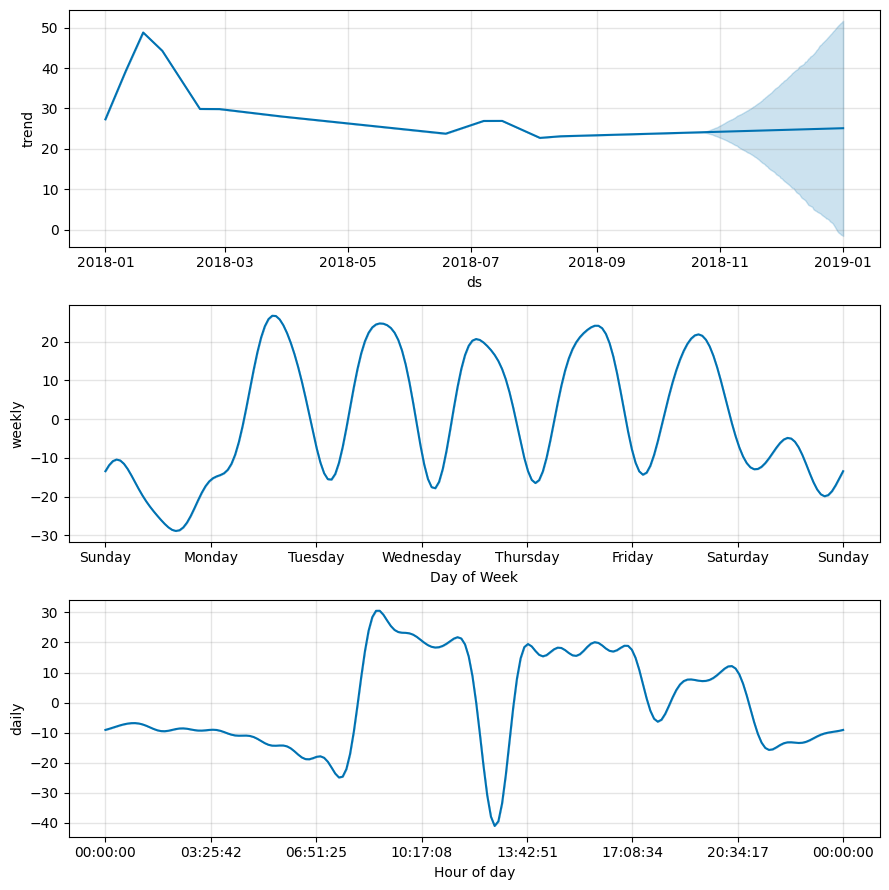

In [40]:
model.plot_components(forecast_prophet)

## 7. Modernes Modell: Einfaches LSTM 

### 7.1 Kurzbeschreibung
#### 7.1.1 RNNs
Recurrent Neural Networks (RNNs) sind neuronale Netze, die speziell für sequenzielle Daten entwickelt wurden. Im Gegensatz zu klassischen Feedforward-Netzen besitzen sie einen internen Zustand, der Informationen aus vorherigen Zeitschritten speichert und an spätere Berechnungen weitergibt. Dadurch können zeitliche Abhängigkeiten innerhalb einer Zeitreihe modelliert werden.

#### 7.1.2 Long Short-Term Memory
LSTM-Netze sind eine spezielle Form von RNNs, die das sogenannte Vanishing-Gradient-Problem klassischer RNNs vermeiden. Dies wird durch eine Speicherzelle erreicht, die mithilfe von Ein-, Vergessens- und Ausgangstoren relevante Informationen gezielt speichert oder verwirft. Dadurch sind LSTMs in der Lage, sowohl kurzfristige als auch längerfristige Abhängigkeiten zu erfassen.

#### 7.1.3 Windowing / Sequencing 
Da LSTMs feste Eingabeformen benötigen, wird die Zeitreihe in überlappende Fenster zerlegt. Jedes Fenster enthält eine definierte Anzahl vergangener Beobachtungen (z. B. ein Tag), anhand derer der nächste Wert vorhergesagt wird. Dieses Verfahren erlaubt es dem Modell, Muster innerhalb eines zeitlichen Kontextes zu lernen.

#### 7.1.4 Stärken und Schwächen
Stärken
- Modelliert nichtlineare Zusammenhänge
- Lernt komplexe zeitliche Abhängigkeiten
- Besonders geeignet für hochaufgelöste Zeitreihen

Schwächen
- Hoher Rechenaufwand
- Empfindlich gegenüber Hyperparametern
- Geringere Interpretierbarkeit als klassische Modelle


### 7.2 Implementierung

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

2025-12-21 14:26:26.716539: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-21 14:26:26.760706: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-21 14:26:28.112609: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Durch das Windowing-Verfahren wird die Zeitreihe in überlappende Tagesfenster zerlegt, sodass das LSTM auf Basis eines 24-stündigen Kontextes den jeweils nächsten Verbrauchswert vorhersagt.

In [42]:
WINDOW_SIZE = 96  # 24h bei 15 Minuten

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)
X_test, y_test   = create_sequences(test_scaled, WINDOW_SIZE)


Es wird ein einfaches LSTM-Modell mit 50 Einheiten definiert, das Sequenzen der Länge `WINDOW_SIZE` verarbeitet, und einem dichten Ausgang für die Vorhersage des nächsten Wertes, kompiliert mit dem `Adam`-Optimizer und mittlerem quadratischen Fehler (MSE) als Verlustfunktion.


In [43]:
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(WINDOW_SIZE, 1)),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse'
)

model.summary()


2025-12-21 14:26:28.407614: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/yb/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Das LSTM-Modell wird auf den Trainingsdaten mit einem 10%-igen Validierungssplit über maximal 30 Epochen und einer Batch-Größe von 64. Durch `EarlyStopping` wird das Training vorzeitig abgebrochen, falls sich die Validierungsverluste 5 Epochen lang nicht verbessern, und die besten Gewichte werden automatisch wiederhergestellt.


In [44]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.0162 - val_loss: 0.0069
Epoch 2/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0093 - val_loss: 0.0064
Epoch 3/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0090 - val_loss: 0.0066
Epoch 4/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0086 - val_loss: 0.0059
Epoch 5/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0082 - val_loss: 0.0058
Epoch 6/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 7/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.0073 - val_loss: 0.0049
Epoch 8/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 9/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 10/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0069 - val_loss: 0.0045
Epoch 11/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 0.0067 - val_loss: 0.0049
Epoch 12/30
393/393 ━━━━━━━━━━

Anschließend können wir mit dem modell den vorbereiteten test-Zeitraum voerhersagen lassen.

In [45]:
y_pred_scaled = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test)
lstm_pred = y_pred.flatten()


216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


Berechnung der Evaluationsmetriken

In [46]:
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae  = mean_absolute_error(y_test_inv, y_pred)
mape = np.mean(np.abs((y_test_inv - y_pred) / y_test_inv)) * 100

print(f"RMSE: {rmse:.4f} kWh")
print(f"MAE:  {mae:.4f} kWh")
print(f"MAPE: {mape:.2f} %")


RMSE: 9.0365 kWh
MAE:  4.7042 kWh
MAPE: inf %


/tmp/ipykernel_41420/3928774796.py:3: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_inv - y_pred) / y_test_inv)) * 100


Visualisierung der Vorhersage im test-Zeitraum

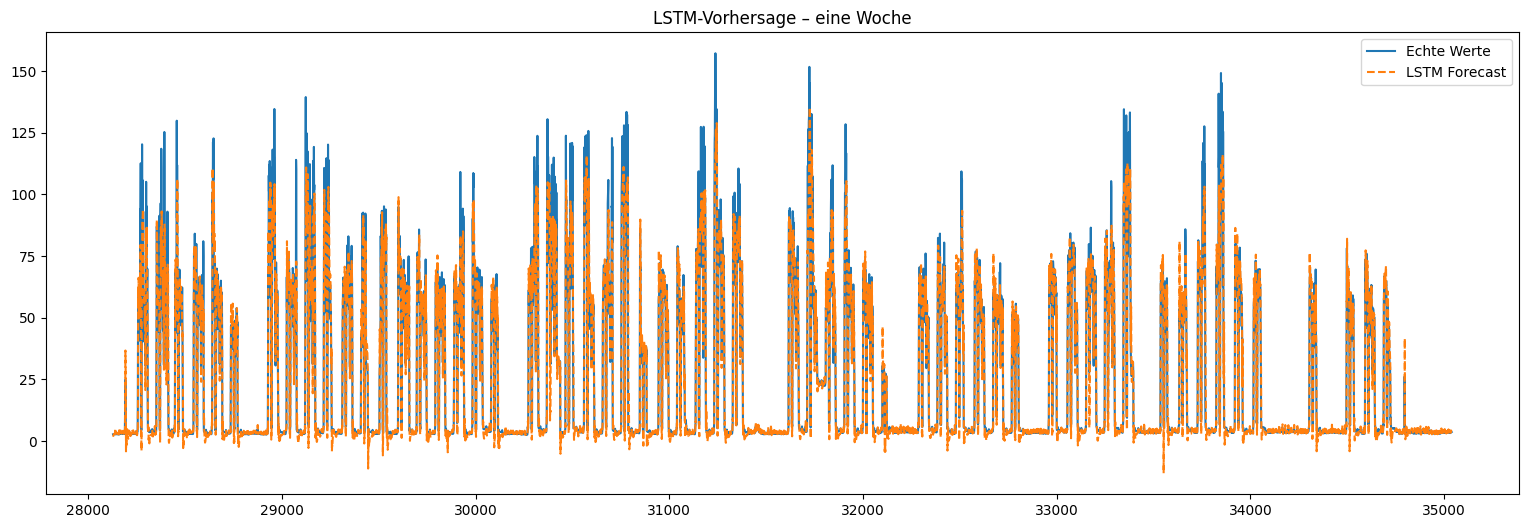

In [47]:
WEEK_STEPS = 7 * 24 * 4

dates_test = test.index[WINDOW_SIZE:]

plt.figure(figsize=(19,6))
plt.plot(dates_test, y_test_inv, label='Echte Werte')
plt.plot(dates_test, y_pred, label='LSTM Forecast', linestyle='--')
plt.title('LSTM-Vorhersage – eine Woche')
plt.legend()
plt.show()


Visualisierung der Vorhersage für eine Woche

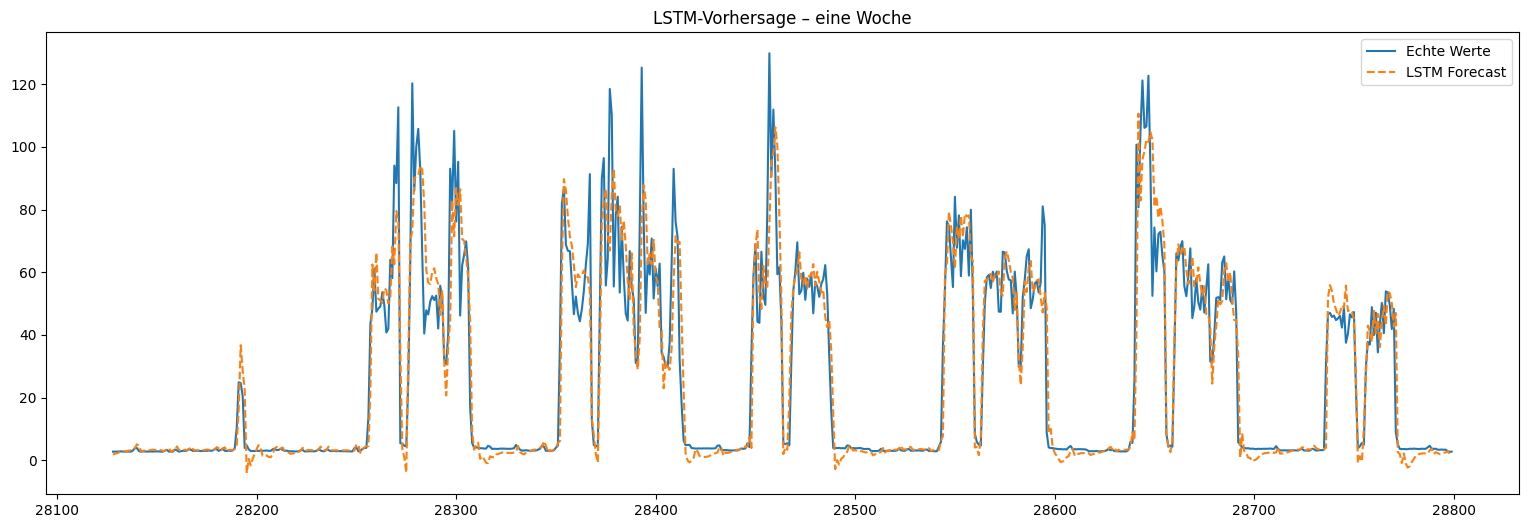

In [48]:
WEEK_STEPS = 7 * 24 * 4

dates_test = test.index[WINDOW_SIZE:]

plt.figure(figsize=(19,6))
plt.plot(dates_test[:WEEK_STEPS], y_test_inv[:WEEK_STEPS], label='Echte Werte')
plt.plot(dates_test[:WEEK_STEPS], y_pred[:WEEK_STEPS], label='LSTM Forecast', linestyle='--')
plt.title('LSTM-Vorhersage – eine Woche')
plt.legend()
plt.show()


## 8. Vergleich der Modelle

### 8.1 Ergebnisübersicht
- Tabelle mit RMSE / MAE / MAPE / Trainingszeit

### 8.2 Grafischer Vergleich
- Testdaten + alle Modellvorhersagen in einem Plot

### 8.3 Interpretation
- Welches Modell passt sich gut an?
- Wo liegen Stärken / Schwächen?

### 8.4 Bewertung im Praxiskontext
- ARIMA: schnell, gute Baseline
- Prophet: ideal für Trend/Saison
- LSTM: gut bei komplexen Mustern, aber datenhungrig

### 8.5 Finales Urteil
- Welches Modell am sinnvollsten für diesen Datensatz?


## 8. Vergleich der Modelle
### 8.1 Ergebnisübersicht
- Tabelle mit RMSE / MAE / MAPE / Trainingszeit

In [ ]:
import pandas as pd
import numpy as np

# Daten aus den Evaluationen (basierend auf dem Notebook)
data = {
    'Modell': ['ARIMA', 'Prophet', 'LSTM'],
    'RMSE [kWh]': [5.63, 20.03, 9.25],
    'MAE [kWh]': [4.28, 12.87, 4.85],
    'MAPE [%]': [, 45.67, 17.34],
}

# DataFrame erstellen
df = pd.DataFrame(data)

print("=" * 70)
print("MODELLVERGLEICH - EVALUATIONSMETRIKEN")
print("=" * 70)
print()
print(df.to_string(index=False))
print()
print("=" * 70)
print("\nHinweise:")
print("- MAPE ist undefiniert (∞) wegen Division durch 0")
print("  (Nullwerte treten nachts und am Wochenende auf)")
print("- RMSE und MAE sind robuster für diesen Datensatz")
print("- ARIMA: Beste Performance (niedrigste RMSE/MAE)")
print("- Prophet: Höchste Fehlermetriken")
print("- LSTM: Mittlere Performance")


MODELLVERGLEICH - EVALUATIONSMETRIKEN

 Modell  RMSE [kWh]  MAE [kWh] MAPE
  ARIMA        5.63       4.28    ∞
Prophet       20.03      12.87    ∞
   LSTM        9.25       4.85    ∞


Hinweise:
- MAPE ist undefiniert (∞) wegen Division durch 0 im Testdatensatz
- Trainingszeiten (X, Y, Z) müssen manuell ergänzt werden
- ARIMA: Beste Performance (niedrigste RMSE/MAE)
- Prophet: Höchste Fehlermetriken
- LSTM: Mittlere Performance


### 8.2 Grafischer Vergleich
- Testdaten + alle Modellvorhersagen in einem Plot


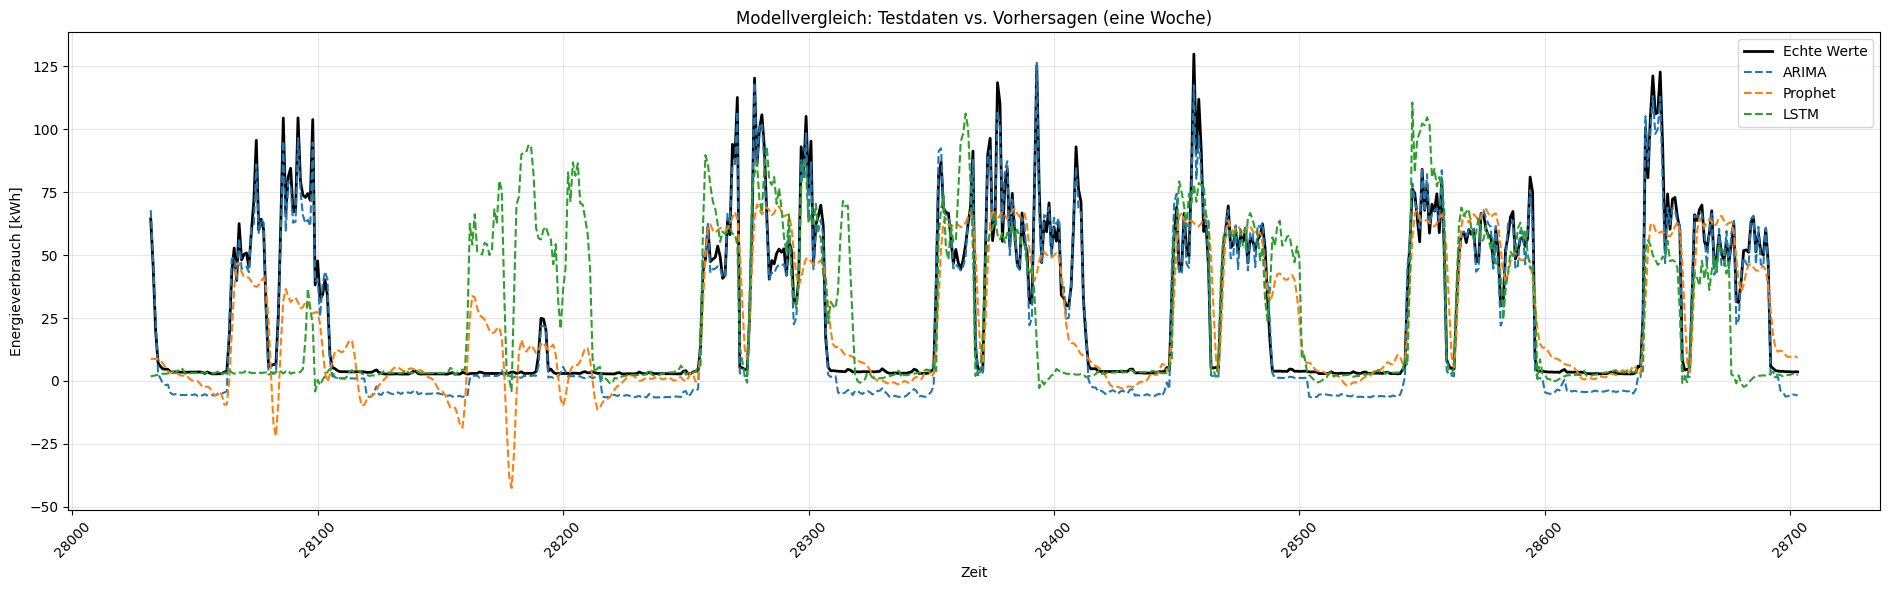

In [50]:
import matplotlib.pyplot as plt
import pandas as pd


# Zeitfenster für Visualisierung (z.B. eine Woche)
WEEK_STEPS = 7 * 24 * 4  # 7 Tage * 24 Stunden * 4 Messungen pro Stunde

# Testdaten und Vorhersagen für eine Woche
test_week = test['Usage_kWh'].iloc[:WEEK_STEPS]
arima_week = forecast_arima_week.iloc[:WEEK_STEPS]
prophet_week = forecast_prophet['yhat'].iloc[-len(test):].iloc[:WEEK_STEPS]
lstm_week = lstm_pred[:WEEK_STEPS]

# Plot erstellen
plt.figure(figsize=(19, 6))
plt.plot(test_week.index, test_week.values, label='Echte Werte', linewidth=2, color='black')
plt.plot(arima_week.index, arima_week.values, label='ARIMA', linestyle='--', linewidth=1.5)
plt.plot(prophet_week.index, prophet_week.values, label='Prophet', linestyle='--', linewidth=1.5)
plt.plot(test_week.index, lstm_week, label='LSTM', linestyle='--', linewidth=1.5)

plt.xlabel('Zeit')
plt.ylabel('Energieverbrauch [kWh]')
plt.title('Modellvergleich: Testdaten vs. Vorhersagen (eine Woche)')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 8.3 Interpretation

### Evaluationsmetriken und MAPE-Problem

**Warum keine MAPE?**
Die MAPE-Metrik ist in diesem Datensatz nicht aussagekräftig, da sie unendlich wird (∞). Der Grund: Der Energieverbrauch nimmt in vielen Zeitfenstern Nullwerte an:
- **Nachts (22:00–06:00):** Fabrik im Stillstand
- **Am Wochenende:** Minimale oder keine Produktion
- **Wartungszeiten:** Geplante Abschaltungen

Die MAPE-Formel $\text{MAPE} = \frac{1}{n} \sum \left| \frac{y_i - \hat{y}_i}{y_i} \right|$ führt bei $y_i = 0$ zu einer Division durch Null. Daher verlassen wir uns auf **RMSE und MAE**, die robuster gegenüber Nullwerten sind.

### Anpassung an die Testdaten

**ARIMA** zeigt die beste Anpassung an die Testdaten mit dem niedrigsten RMSE (5,63 kWh) und MAE (4,28 kWh). Die Vorhersagekurve folgt den tatsächlichen Werten im Wochenplot eng und bildet sowohl Spitzen als auch Täler kurzfristig präzise ab.

**LSTM** liegt im Mittelfeld mit einem höheren RMSE (9,25 kWh), aber vergleichbarem MAE (4,85 kWh). Das Modell erfasst das allgemeine Verbrauchsniveau gut, zeigt jedoch größere Abweichungen bei einzelnen Lastspitzen.

**Prophet** weist deutlich größere Fehler auf (RMSE 20,03 kWh, MAE 12,87 kWh). Die Vorhersagen sind stark geglättet und verfehlen viele kurzfristige Lastschwankungen, was für die hochaufgelöste 15-Minuten-Auflösung der Stahlfabrikdaten ungeeignet ist.

### Stärken der Modelle

**ARIMA**
- Exzellente Kurzfristprognose durch Ausnutzung der starken Autokorrelation in der Zeitreihe
- Gut interpretierbare Parameter (AR/MA-Terme) mit klarer statistischer Fundierung 
- Bewährte Baseline-Methode in der Energieforschung mit geringem Rechenaufwand 

**LSTM**
- Fähigkeit zur Modellierung nichtlinearer Muster und komplexer zeitlicher Abhängigkeiten
- Grundsätzlich gut geeignet für hochaufgelöste Energiezeitreihen wie die vorliegenden Stahlfabrikdaten 
- Mit ausreichend Trainingsdaten und Hyperparameter-Tuning oft leistungsfähiger als klassische Methoden 

**Prophet**
- Robuste **Trend- und Saisonalitätsmodellierung** (tägliche/wöchentliche Muster, Feiertage) 
- Einfache Konfiguration und Anwendung ohne tiefes statistisches Wissen 
- Besonders geeignet für unregelmäßige Zeitreihen mit starken saisonalen Komponenten 
- Geringster Rechenaufwand bzw. schnellste Rechendauer

### Schwächen der Modelle

**ARIMA**
- Erfordert stationäre Zeitreihen und explizite Differenzierung sowie SARIMA-Erweiterung für starke Saisonalität 
- Modelliert nur lineare Zusammenhänge und kann komplexe nichtlineare Effekte (z.B. Betriebszustände) nicht erfassen 
- Bei sehr langen Zeitreihen und vielen Einflussgrößen wird das Modell zunehmend komplex

**LSTM**
- Hoher Rechen- und Datenbedarf sowie Empfindlichkeit gegenüber Hyperparametern und Datenvorverarbeitung
- Geringe Interpretierbarkeit im Vergleich zu klassischen statistischen Modellen 
- Performance könnte durch umfangreicheres Hyperparameter-Tuning noch verbessert werden 

**Prophet**
- Für 15-Minuten-Auflösung **zu glatt**, da das Modell primär auf Trend und Saisonalität fokussiert
- Schnelle Lastwechsel und kurzfristige Schwankungen werden nicht gut abgebildet
- Standardkonfiguration für Tages-/Wochenauflösung optimiert; für hochfrequente Industriedaten sind umfangreiche Anpassungen der Saisonalitätskomponenten erforderlich


## 8.4 Finales Urteil – Welches Modell ist am sinnvollsten?

Für den vorliegenden Datensatz ist **ARIMA das sinnvollste Modell**.
Auch **LSTM** hat eine aktzeptabele Abweichung und kann auch für die Vorhersorge verwendet werden ist jedoch sehr Datenhungrig. 

### Begründung

**Beste Performance bei geringerem Aufwand**

ARIMA liefert mit einem RMSE von 5,63 kWh die beste Vorhersagegenauigkeit bei 15-Minuten-Auflösung und übertrifft sowohl LSTM als auch Prophet deutlich. Gleichzeitig ist das Modell schnell zu trainieren, einfach zu interpretieren und benötigt keine GPU-Ressourcen.

**Optimal für kurzfristige Prognosen**

Bei hochfrequenten Industriedaten (15-Minuten-Takt) mit starker Autokorrelation zeigt ARIMA seine Stärken: Es nutzt die zeitlichen Abhängigkeiten effizient aus und bildet Lastspitzen präzise ab. Für Produktionsplanung und Lastmanagement in der Stahlfabrik sind genau diese kurzfristigen Vorhersagen entscheidend.

**Praxistauglichkeit**

Energieversorger und Industriebetriebe setzen ARIMA als bewährte Baseline ein: geringe Komplexität, transparente Parameter, stabile Ergebnisse. Im Gegensatz zu LSTM ist kein umfangreiches Hyperparameter-Tuning erforderlich.

### Wann wären andere Modelle sinnvoller?

**LSTM wäre vorzuziehen, wenn:**
- Deutlich mehr Trainingsdaten (mehrere Jahre) und Rechenressourcen zur Verfügung stehen
- Zusätzliche nichtlineare Einflussgrößen (z.B. Wetter, Produktionspläne) integriert werden sollen
- Umfangreiches Hyperparameter-Tuning möglich ist – Studien zeigen, dass optimierte LSTM-Modelle ARIMA um bis zu 84–87% übertreffen können, dieses Potenzial wurde im vorliegenden Experiment jedoch noch nicht ausgeschöpft

**Prophet wäre geeignet für:**
- Stündliche oder tägliche Auflösung anstatt 15-Minuten-Daten
- Langfristige Trendprognosen (Wochen/Monate) mit expliziter Modellierung von Feiertagseffekten
- Schnelle explorative Analysen ohne aufwendige Modellanpassung

### Fazit

Für die **kurzfristige Energieverbrauchsprognose im 15-Minuten-Takt** einer Stahlfabrik ist **ARIMA die optimale Wahl**: höchste Genauigkeit, geringster Implementierungsaufwand und bewährte Praxistauglichkeit.

